We start by loading the labels and fourier features extracted from the time series. The extracting process took more than a day to run.

In [0]:
import numpy as np
feats_fourier = np.load("fourier10.npy")
feats_FATS = np.load("Features.npy")
feats_FATS = feats_FATS[:,~np.isnan(feats).any(axis=0)]
labs = np.load("true_labels.npy")

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.ensemble as ske

We look at the Fourier features for some of the rarer classes:

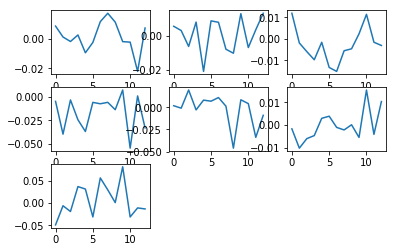

In [23]:
a = np.where([labs == 12])[1]
for i in range(0, 7):
    r = a[i]
    plt.subplot(330 + 1 + i)
    plt.plot(feats_fourier[r,2:15])
plt.show();

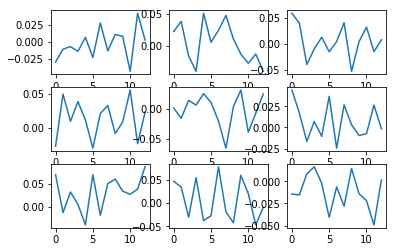

In [24]:
a = np.where([labs == 15])[1]
for i in range(0, 9):
    r = a[i]
    plt.subplot(330 + 1 + i)
    plt.plot(feats_fourier[r,2:15])
plt.show();

We divide the full data into **test-train**. We carefully choose a fixed proportion, say $0.1$, of representatives from every class in our training data. This ensures that the training will allow information from the rarer classes to seep in.

In [0]:
np.random.seed(100)
probb = 0.1
test = []
for i in set(labs):
    a = np.where([labs == i])[1]
    test.append(np.random.choice(a, size=int(np.ceil(len(a)*probb))))

In [0]:
import itertools 
test_ind = list(itertools.chain(*test))
train_ind = np.setdiff1d(np.arange(len(labs)), test_ind)

We check the class sizes in the training data.

In [27]:
from collections import Counter
Counter(labs[train_ind])

Counter({1: 27673,
         2: 4212,
         3: 252,
         4: 2193,
         5: 4907,
         6: 452,
         7: 64,
         8: 1366,
         9: 56,
         10: 112,
         11: 218,
         12: 6,
         13: 461,
         14: 128,
         15: 22,
         16: 77,
         17: 137})

Next, we implement **oversampling**,  where we fix a minimum class size while sampling from the training data.

In [0]:
min_class_size = 5000
oversamp = np.arange(len(train_ind))
for i in set(labs):
    a = np.where([labs[train_ind] == i])[1]
    ntimes = int(np.ceil(min_class_size / len(a)) - 1) 
    for i in np.arange(ntimes):
        oversamp = np.append(oversamp, a)

Here are the class sizes after the rarer classes have been oversampled.
Observe, we DONOT implement data augmentation, just use exact copies, and hence we have the **risk of overfitting**.

In [29]:
Counter(labs[train_ind[oversamp]])

Counter({1: 27673,
         2: 8424,
         3: 5040,
         4: 6579,
         5: 9814,
         6: 5424,
         7: 5056,
         8: 5464,
         9: 5040,
         10: 5040,
         11: 5014,
         12: 5004,
         13: 5071,
         14: 5120,
         15: 5016,
         16: 5005,
         17: 5069})

We use random forest classifier on the Fourier features.
First, let us look at performance **without oversampling**.

In [30]:
import sklearn.ensemble as ske
rf_fourier = ske.RandomForestClassifier(random_state = 10).fit(feats_fourier[train_ind,:], labs[train_ind])

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Correct Classification Percentage: 0.6444254956299297


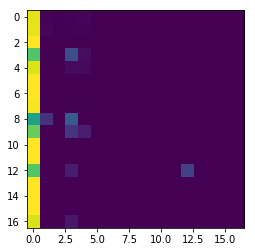

In [37]:
from sklearn import metrics
cm = metrics.confusion_matrix(labs[test_ind], rf_fourier.predict(feats_fourier[test_ind,:]))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm);
print('Correct Classification Percentage:',sum(labs[test_ind] == rf_fourier.predict(feats_fourier[test_ind,:]))/ len(test_ind))

The performance is terrible, as  **nearly everything is being classified to the first class, which is the largest class**.
Let's look at correct classification percentage:

This is poor, so we try **oversampling** now.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Correct Classification Percentage: 0.6254529950969943


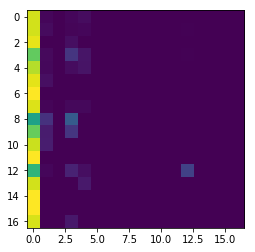

In [38]:
rf2_fourier= ske.RandomForestClassifier(random_state = 10).fit(feats_fourier[train_ind[oversamp],:], labs[train_ind[oversamp]])

cm_over = metrics.confusion_matrix(labs[test_ind], rf2_fourier.predict(feats_fourier[test_ind,:]))
cm_over = cm_over.astype('float') / cm_over.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_over);

print('Correct Classification Percentage:',sum(labs[test_ind] == rf2_fourier.predict(feats_fourier[test_ind,:]))/ len(test_ind))

We can clearly see **performance actually worsens**, partially because the features are bad themselves, and partially owing to overfiting.

In conclusion, the Fourier features are too noisy to be well-separated during classification, and hence fails.

We move on to using FATS.

In [3]:
!git clone https://github.com/the-kidd17/forcollabforked
%cd forcollabforked/

Cloning into 'forcollabforked'...
remote: Enumerating objects: 11, done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 11
Unpacking objects: 100% (11/11), done.
/content/forcollabforked


In [0]:
files.upload()

Saving Features.npy to Features (1).npy


In [0]:
feats_FATS = np.load("Features.npy")
feats_FATS = feats_FATS[:,~np.isnan(feats_FATS).any(axis=0)]

We first classify **without oversampling.**

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Correct Classification Percentage: 0.6452781922830952


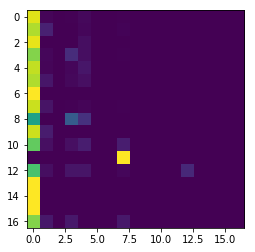

In [39]:

rf_FATS = ske.RandomForestClassifier(random_state = 10).fit(feats_FATS[train_ind,:], labs[train_ind])

cm = metrics.confusion_matrix(labs[test_ind], rf_FATS.predict(feats_FATS[test_ind,:]))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm);

print('Correct Classification Percentage:',sum(labs[test_ind] == rf_FATS.predict(feats_FATS[test_ind,:]))/ len(test_ind))

We observe, FATS features perform **slightly better** than Fourier features, may be because there are more FATS features, or perhaps because the Fourier features were way too noisy.

Still, overall classifiaction is still disastrous. Let's try with **oversampling**.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Correct Classification Percentage: 0.6309955233425709


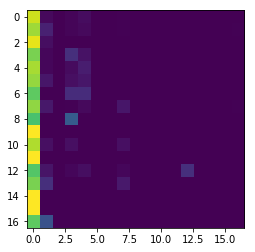

In [40]:
rf2_FATS = ske.RandomForestClassifier(random_state = 10).fit(feats_FATS[train_ind[oversamp],:], labs[train_ind[oversamp]])

cm = metrics.confusion_matrix(labs[test_ind], rf2_FATS.predict(feats_FATS[test_ind,:]))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm);

print('Correct Classification Percentage:',sum(labs[test_ind] == rf2_FATS.predict(feats_FATS[test_ind,:]))/ len(test_ind))

Classification rate is still bad, and **worse** with oversampling.